# konlpy과 Mecab 설치 방법

In [1]:
from IPython.display import clear_output
from time import sleep
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1
!pip3 install konlpy
sleep(3)
clear_output()

In [2]:
!pip3 install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!echo "$JAVA_HOME"

In [4]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh) 
!pip3 install /tmp/mecab-python-0.996
sleep(2)
clear_output()

In [5]:
from konlpy.tag import Mecab

In [6]:
mecab = Mecab()
sentence = "비자림조 화이팅이에요!! :)"
mecab.morphs(sentence)

['비자림', '조', '화이팅', '이', '에요', '!', '!', ':', ')']

# 영화리뷰 텍스트 감성분석하기

# 데이터 불러오기

In [7]:
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from gensim.models.keyedvectors import Word2VecKeyedVectors

from gensim.models import KeyedVectors

from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pprint

import gensim
import gensim.models

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [ ]:
import os
import re
import pandas as pd
import numpy as np

import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline


from konlpy.tag import Okt
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [8]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/AIFFEL/EXP/data/movie_review/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/AIFFEL/EXP/data/movie_review/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [10]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  #인덱스 정의
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
  

In [11]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [13]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [14]:
len(word_to_index)

10000

In [15]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# Preprocessing

In [16]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [17]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

In [18]:
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [19]:
# validation set 30000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

In [20]:
print(x_val.shape)
print(y_val.shape)
print(partial_x_train.shape)
print(partial_y_train.shape)

(30000, 41)
(30000,)
(116182, 41)
(116182,)


# LSTM

In [21]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_LSTM.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_LSTM.add(keras.layers.Dense(8, activation='relu'))
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 235,281
Trainable params: 235,281
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# check = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [24]:
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

review = model_LSTM.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
3631/3631 [==============================] - 26s 5ms/step - loss: 0.3852 - accuracy: 0.8257 - val_loss: 0.3365 - val_accuracy: 0.8519
Epoch 2/20
3631/3631 [==============================] - 20s 5ms/step - loss: 0.3057 - accuracy: 0.8698 - val_loss: 0.3214 - val_accuracy: 0.8619
Epoch 3/20
3631/3631 [==============================] - 20s 5ms/step - loss: 0.2681 - accuracy: 0.8873 - val_loss: 0.3249 - val_accuracy: 0.8619
Epoch 4/20
3631/3631 [==============================] - 19s 5ms/step - loss: 0.2403 - accuracy: 0.9002 - val_loss: 0.3267 - val_accuracy: 0.8597
Epoch 5/20
3631/3631 [==============================] - 20s 5ms/step - loss: 0.2177 - accuracy: 0.9109 - val_loss: 0.3496 - val_accuracy: 0.8613
Epoch 6/20
3631/3631 [==============================] - 19s 5ms/step - loss: 0.1929 - accuracy: 0.9221 - val_loss: 0.3615 - val_accuracy: 0.8576
Epoch 7/20
3631/3631 [==============================] - 19s 5ms/step - loss: 0.1704 - accuracy: 0.9327 - val_loss: 0.3916 - val_ac

In [25]:
#학습이 끝난 모델을 테스트셋으로 평가
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0837 - accuracy: 0.8319 - 3s/epoch - 2ms/step
[1.0836782455444336, 0.831885576248169]


accuracy : 83.18 % 

In [26]:
review_dict = review.history
print(review_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## 그래프

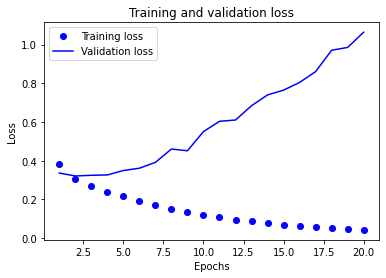

In [27]:
acc = review_dict['accuracy']
val_acc = review_dict['val_accuracy']
loss = review_dict['loss']
val_loss = review_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

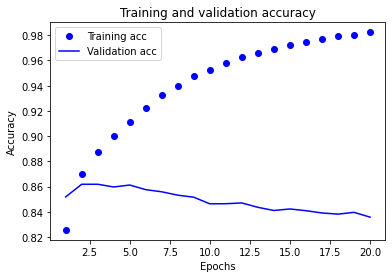

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Embedding layer

In [29]:
embedding_layer = model_LSTM.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [30]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/AIFFEL/EXP/data/movie_review/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['친구']
vector

array([-0.03906744,  0.09555871, -0.2965842 ,  0.0329673 , -0.23527147,
       -0.14623113,  0.04566725, -0.16282211,  0.11512919, -0.02190597,
       -0.00934538,  0.08229231,  0.09321594, -0.01511034,  0.29810435,
        0.00748699], dtype=float32)

In [33]:
word_vectors.similar_by_word("친구")

[('선정', 0.7508346438407898),
 ('ㅅ', 0.7237610816955566),
 ('음식', 0.7235318422317505),
 ('환', 0.706780195236206),
 ('세포', 0.7006998062133789),
 ('음란', 0.6899730563163757),
 ('저버리', 0.6806926727294922),
 ('마이', 0.680436372756958),
 ('쥔', 0.6728217601776123),
 ('가문', 0.6721794605255127)]

In [34]:
word_vectors.similar_by_word("벗")

[('기반', 0.8819068670272827),
 ('파탄', 0.8674823641777039),
 ('논리', 0.8644260168075562),
 ('관객', 0.8549259901046753),
 ('그렇', 0.8548225164413452),
 ('만드셨', 0.8511418700218201),
 ('자다', 0.8492459058761597),
 ('평이', 0.8483477830886841),
 ('감흥', 0.8459151983261108),
 ('그닥', 0.8364166021347046)]

# 한국어 Word2Vec


In [36]:
word2vec_path = '/content/drive/MyDrive/AIFFEL/EXP/data/movie_review/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['인간']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 0.4703588 , -0.16424303,  1.3168608 ,  1.4243106 , -1.86046   ,
       -0.06605004, -2.2504544 ,  0.68588257,  0.3204627 , -0.42963967,
        0.14152947,  0.7610687 , -1.4909712 , -2.6823092 ,  1.4991912 ,
        1.5117878 ,  1.7588547 ,  0.20618425,  0.39005193,  2.1376972 ,
       -0.4476696 ,  0.92691714,  1.727673  ,  0.45050302,  0.40347716,
        1.4998629 ,  0.8201128 ,  0.68093646, -1.3267987 , -0.6275506 ,
        0.41182595,  0.466942  , -0.45215124, -3.1827824 , -0.6823195 ,
        0.10134491,  0.58721626, -1.9497797 ,  1.9593389 ,  2.5694413 ,
        0.8241642 ,  1.1542562 ,  0.15225063, -2.0806491 ,  0.7984272 ,
        0.9928375 ,  1.6686137 ,  0.72827774,  2.171416  , -0.36715144,
       -0.8043339 , -1.1726975 ,  1.1168605 , -0.2578816 , -2.0645244 ,
        0.4110174 ,  0.39715552, -1.5894676 , -0.6499789 ,  1.6438806 ,
        1.1233037 ,  2.4566605 ,  2.2384021 , -0.7890777 , -0.18891379,
        0.41238904, -0.23069689,  1.7084748 ,  1.5715443 , -0.56

In [37]:
word2vec.similar_by_word("인간")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('본능', 0.673734188079834),
 ('자아', 0.6703100204467773),
 ('본질', 0.6514253616333008),
 ('인류', 0.6405942440032959),
 ('육체', 0.6381494402885437),
 ('욕망', 0.625582218170166),
 ('유기체', 0.6206836700439453),
 ('인격', 0.6146934032440186),
 ('지성', 0.6025905609130859),
 ('본성', 0.6012983322143555)]

In [38]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [39]:
vocab_size = 10000
word_vector_dim = 200

LSTM_ko = keras.Sequential()
LSTM_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM_ko.add(keras.layers.LSTM(64))
LSTM_ko.add(keras.layers.Dense(256, activation='relu'))
LSTM_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [40]:
LSTM_ko.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                67840     
                                                                 
 dense_2 (Dense)             (None, 256)               16640     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,084,737
Trainable params: 2,084,737
Non-trainable params: 0
_________________________________________________________________


In [41]:
LSTM_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
ealry_ko = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check_ko = ModelCheckpoint('best_model_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [43]:
history = LSTM_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[ealry_ko, check_ko],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3629/3631 [============================>.] - ETA: 0s - loss: 0.3879 - accuracy: 0.8234
Epoch 1: saving model to best_model_ko.h5
3631/3631 [==============================] - 24s 6ms/step - loss: 0.3878 - accuracy: 0.8235 - val_loss: 0.3252 - val_accuracy: 0.8573
Epoch 2/20
3625/3631 [============================>.] - ETA: 0s - loss: 0.2932 - accuracy: 0.8767
Epoch 2: saving model to best_model_ko.h5
3631/3631 [==============================] - 21s 6ms/step - loss: 0.2933 - accuracy: 0.8766 - val_loss: 0.3158 - val_accuracy: 0.8635
Epoch 3/20
3622/3631 [============================>.] - ETA: 0s - loss: 0.2504 - accuracy: 0.8959
Epoch 3: saving model to best_model_ko.h5
3631/3631 [==============================] - 22s 6ms/step - loss: 0.2504 - accuracy: 0.8959 - val_loss: 0.3282 - val_accuracy: 0.8643
Epoch 4/20
3627/3631 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9128
Epoch 4: saving model to best_model_ko.h5
3631/3631 [===========================

In [ ]:
loaded_model = load_model('best_model_ko.h5')
results = loaded_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4569 - accuracy: 0.8535 - 4s/epoch - 3ms/step
[0.4568541646003723, 0.8535305261611938]


accuracy : 85.35%

# Conv1D

In [ ]:
vocab_size = 10000
word_vector_dim = 64

conv1d_model = keras.Sequential()
conv1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.MaxPooling1D(5))
conv1d_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model.add(keras.layers.GlobalMaxPooling1D())
conv1d_model.add(keras.layers.Dense(128, activation='relu'))
conv1d_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
conv1d_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 conv1d (Conv1D)             (None, None, 64)          28736     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          28736     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
conv1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
conv1d_history = conv1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 24s 5ms/step - loss: 0.3677 - accuracy: 0.8333 - val_loss: 0.3173 - val_accuracy: 0.8620
Epoch 2/10
3631/3631 [==============================] - 16s 4ms/step - loss: 0.2647 - accuracy: 0.8899 - val_loss: 0.3196 - val_accuracy: 0.8603
Epoch 3/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.1827 - accuracy: 0.9276 - val_loss: 0.3627 - val_accuracy: 0.8567
Epoch 4/10
3631/3631 [==============================] - 16s 5ms/step - loss: 0.1166 - accuracy: 0.9554 - val_loss: 0.4654 - val_accuracy: 0.8533
Epoch 5/10
3631/3631 [==============================] - 17s 5ms/step - loss: 0.0799 - accuracy: 0.9699 - val_loss: 0.5359 - val_accuracy: 0.8510
Epoch 6/10
3631/3631 [==============================] - 16s 4ms/step - loss: 0.0603 - accuracy: 0.9770 - val_loss: 0.6560 - val_accuracy: 0.8455
Epoch 7/10
3631/3631 [==============================] - 16s 5ms/step - loss: 0.0484 - accuracy: 0.9818 - val_loss: 0.7842 - val_ac

In [ ]:
results = conv1d_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9652 - accuracy: 0.8402 - 3s/epoch - 2ms/step
[0.9651979804039001, 0.8402262330055237]


accurach : 84%

In [ ]:
conv1d_history_dict = conv1d_history.history

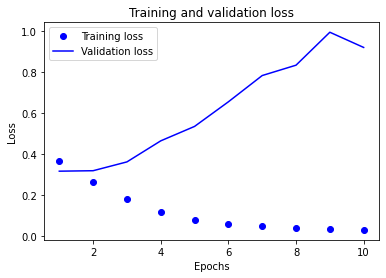

In [ ]:
acc = conv1d_history_dict['accuracy']
val_acc = conv1d_history_dict['val_accuracy']
loss = conv1d_history_dict['loss']
val_loss = conv1d_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

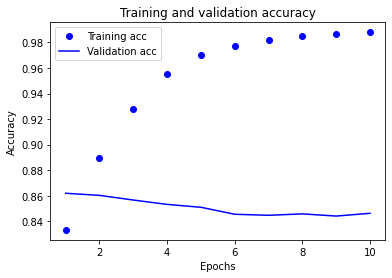

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [ ]:
word2vec_file_path = '/content/drive/MyDrive/AIFFEL/EXP/data/movie_review/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['아들']
vector

array([-0.10537486, -0.33306545,  0.15040307,  0.10114589, -0.02515052,
        0.07410725,  0.15726711, -0.02907477,  0.08007453, -0.17821805,
       -0.2601392 , -0.19492784, -0.25377944, -0.23375772,  0.11187929,
       -0.00951528, -0.06341738,  0.0298382 , -0.0080433 ,  0.15755881,
        0.21488853, -0.06778713,  0.03433593,  0.00266081,  0.06633412,
        0.02902787,  0.14914706, -0.07012396, -0.04092298, -0.11568876,
       -0.3515063 ,  0.06571978,  0.02165599,  0.1873585 , -0.24276645,
       -0.03137745,  0.01790927, -0.21245973,  0.07914107,  0.29815823,
       -0.6404851 ,  0.02386776,  0.04429381, -0.06029964, -0.01929061,
        0.06928629,  0.03094419, -0.22660075,  0.04061832,  0.01094161,
        0.1305367 ,  0.42470726, -0.0956565 , -0.0130123 ,  0.10595514,
        0.10509326, -0.17522493, -0.13967144, -0.15809958, -0.09197765,
       -0.07430796,  0.11201451, -0.14634374, -0.17494573], dtype=float32)

In [ ]:
word_vectors.similar_by_word("자식")

[(".'", 0.5405640602111816),
 ('어린이', 0.5237715244293213),
 ('혹은', 0.4674091935157776),
 ('늘', 0.46112409234046936),
 ('으러', 0.4602969288825989),
 ('나와서', 0.4467007517814636),
 ('이번', 0.44104626774787903),
 ('보네', 0.43709254264831543),
 ('클로이', 0.4323579668998718),
 ('넘', 0.4318857789039612)]

In [ ]:
word2vec_path = '/content/drive/MyDrive/AIFFEL/EXP/data/movie_review/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['아들']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 3.2425485e+00, -6.9091606e-01,  6.7467242e-01,  5.1220530e-01,
       -3.3618692e-02,  5.2010423e-01,  2.1943602e-01,  1.4599502e+00,
        3.2977831e-01,  1.5316870e+00,  8.7768036e-01,  1.0395159e+00,
       -2.5627210e+00, -9.5821202e-01,  3.7557607e+00,  2.1280668e+00,
        2.3859262e-01, -5.7243001e-01,  2.2473879e+00, -2.6272056e-01,
        2.0151258e+00, -2.2846072e+00, -1.2897599e+00,  9.0100700e-01,
        4.9171737e-01,  1.5227786e-01,  1.5983281e+00, -1.1609588e+00,
        1.4252837e-01,  2.2021818e+00,  7.3860906e-02, -3.9674488e-01,
        8.3856297e-01, -5.9536028e-01,  1.7360221e+00, -1.1328205e+00,
       -2.9783504e+00, -1.6562676e+00,  1.0860201e+00, -1.9646174e+00,
       -1.4820768e+00,  1.0652651e+00,  1.5172271e+00, -3.1749434e+00,
        2.3078265e+00, -1.1155503e+00, -2.1844237e+00, -4.3558034e-01,
       -3.4122989e-01, -1.4310317e+00, -2.5629711e+00, -6.9784302e-01,
        1.8571497e+00,  7.2290826e-01,  1.1685777e+00,  7.4327755e-01,
      

In [ ]:
word2vec.similar_by_word("아파트")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('상가', 0.698958158493042),
 ('맨션', 0.693806529045105),
 ('오피스텔', 0.6663815379142761),
 ('주택', 0.631797194480896),
 ('주차장', 0.6229800581932068),
 ('주택가', 0.6041041612625122),
 ('빌딩', 0.6035054326057434),
 ('부지', 0.5963238477706909),
 ('주유소', 0.5833803415298462),
 ('압구정동', 0.5720449090003967)]

In [ ]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
vocab_size = 10000
word_vector_dim = 200

LSTM_ko = keras.Sequential()
LSTM_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
LSTM_ko.add(keras.layers.LSTM(64))
LSTM_ko.add(keras.layers.Dense(256, activation='relu'))
LSTM_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
conv1d_model_ko.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 64)            89664     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             28736     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 128)              

In [ ]:
conv1d_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = conv1d_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 19s 5ms/step - loss: 0.4246 - accuracy: 0.7994 - val_loss: 0.3455 - val_accuracy: 0.8467
Epoch 2/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.3142 - accuracy: 0.8663 - val_loss: 0.3379 - val_accuracy: 0.8533
Epoch 3/10
3631/3631 [==============================] - 19s 5ms/step - loss: 0.2677 - accuracy: 0.8875 - val_loss: 0.3362 - val_accuracy: 0.8561
Epoch 4/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.2232 - accuracy: 0.9085 - val_loss: 0.3506 - val_accuracy: 0.8546
Epoch 5/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.1800 - accuracy: 0.9272 - val_loss: 0.3810 - val_accuracy: 0.8501
Epoch 6/10
3631/3631 [==============================] - 18s 5ms/step - loss: 0.1427 - accuracy: 0.9436 - val_loss: 0.4531 - val_accuracy: 0.8515
Epoch 7/10
3631/3631 [==============================] - 19s 5ms/step - loss: 0.1134 - accuracy: 0.9555 - val_loss: 0.5493 - val_ac

In [ ]:
results = conv1d_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7414 - accuracy: 0.8442 - 3s/epoch - 2ms/step
[0.741395890712738, 0.8442338109016418]


accuracy : 84.4 %

# GlobalMaxPooling

In [ ]:
vocab_size = 10000
word_vector_dim = 64

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
GMP_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          640000    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.3926 - accuracy: 0.8250 - val_loss: 0.3434 - val_accuracy: 0.8507
Epoch 2/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.3030 - accuracy: 0.8724 - val_loss: 0.3374 - val_accuracy: 0.8546
Epoch 3/10
3631/3631 [==============================] - 13s 3ms/step - loss: 0.2604 - accuracy: 0.8931 - val_loss: 0.3455 - val_accuracy: 0.8537
Epoch 4/10
3631/3631 [==============================] - 13s 4ms/step - loss: 0.2247 - accuracy: 0.9101 - val_loss: 0.3651 - val_accuracy: 0.8515
Epoch 5/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.1921 - accuracy: 0.9256 - val_loss: 0.3950 - val_accuracy: 0.8481
Epoch 6/10
3631/3631 [==============================] - 12s 3ms/step - loss: 0.1621 - accuracy: 0.9393 - val_loss: 0.4369 - val_accuracy: 0.8456
Epoch 7/10
3631/3631 [==============================] - 13s 3ms/step - loss: 0.1362 - accuracy: 0.9500 - val_loss: 0.4810 - val_ac

In [ ]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6503 - accuracy: 0.8287 - 2s/epoch - 2ms/step
[0.650305449962616, 0.828671395778656]


In [ ]:
GMP_history_dict = GMP_history.history

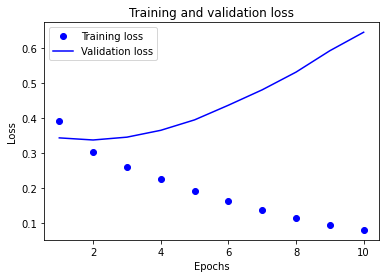

In [ ]:
acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

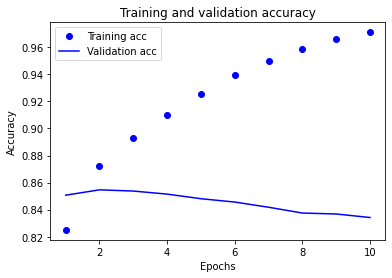

In [ ]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
embedding_layer = GMP_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [ ]:
word2vec_file_path ='/content/drive/MyDrive/AIFFEL/EXP/data/movie_review/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = GMP_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.01676973, -0.19388936, -0.08013088, -0.0387539 , -0.13686816,
        0.13260438, -0.11708039,  0.2702344 ,  0.03854675, -0.05934923,
       -0.15654953, -0.23276724,  0.09429263, -0.11051847, -0.08031243,
       -0.18749553, -0.16914333, -0.18747482, -0.04912965,  0.05290202,
        0.05638668,  0.13981254, -0.13209759, -0.16503999, -0.1635617 ,
       -0.21061578, -0.12925413,  0.23432985, -0.20368834, -0.16892855,
       -0.12353002, -0.18840979,  0.0784569 ,  0.02209095, -0.17616871,
       -0.0319198 ,  0.23274049, -0.01473417, -0.11221359, -0.09500123,
       -0.0367211 ,  0.07561267, -0.05522439, -0.10504895, -0.03368733,
       -0.16320182, -0.19863963, -0.04380166,  0.00320414, -0.00727908,
       -0.00355263,  0.4063524 , -0.2731679 ,  0.10631743, -0.25521868,
        0.02393263, -0.01579316, -0.18713878, -0.05881396, -0.19998531,
       -0.0265929 , -0.08380789, -0.00599942, -0.23267968], dtype=float32)

In [ ]:
word_vectors.similar_by_word("감동")

[('만점', 0.8384409546852112),
 ('추억', 0.8019517660140991),
 ('괜찮', 0.767042875289917),
 ('픽사', 0.758162260055542),
 ('g', 0.7569925785064697),
 ('유쾌', 0.7547305822372437),
 ('아픈', 0.7534957528114319),
 ('든', 0.7524678707122803),
 ('손예진', 0.7488901615142822),
 ('디즈니', 0.7431817054748535)]

# 한국어 Word2Vec

In [ ]:
word2vec_path = '/content/drive/MyDrive/AIFFEL/EXP/data/movie_review/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['아들']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 3.2425485e+00, -6.9091606e-01,  6.7467242e-01,  5.1220530e-01,
       -3.3618692e-02,  5.2010423e-01,  2.1943602e-01,  1.4599502e+00,
        3.2977831e-01,  1.5316870e+00,  8.7768036e-01,  1.0395159e+00,
       -2.5627210e+00, -9.5821202e-01,  3.7557607e+00,  2.1280668e+00,
        2.3859262e-01, -5.7243001e-01,  2.2473879e+00, -2.6272056e-01,
        2.0151258e+00, -2.2846072e+00, -1.2897599e+00,  9.0100700e-01,
        4.9171737e-01,  1.5227786e-01,  1.5983281e+00, -1.1609588e+00,
        1.4252837e-01,  2.2021818e+00,  7.3860906e-02, -3.9674488e-01,
        8.3856297e-01, -5.9536028e-01,  1.7360221e+00, -1.1328205e+00,
       -2.9783504e+00, -1.6562676e+00,  1.0860201e+00, -1.9646174e+00,
       -1.4820768e+00,  1.0652651e+00,  1.5172271e+00, -3.1749434e+00,
        2.3078265e+00, -1.1155503e+00, -2.1844237e+00, -4.3558034e-01,
       -3.4122989e-01, -1.4310317e+00, -2.5629711e+00, -6.9784302e-01,
        1.8571497e+00,  7.2290826e-01,  1.1685777e+00,  7.4327755e-01,
      

In [ ]:
word2vec.similar_by_word("감동")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [ ]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
vocab_size = 10000
word_vector_dim = 200

GMP_model_ko = keras.Sequential()
GMP_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
GMP_model_ko.add(keras.layers.GlobalMaxPooling1D())
GMP_model_ko.add(keras.layers.Dense(8, activation='relu'))
GMP_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
GMP_model_ko.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 8)                 1608      
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [ ]:
GMP_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = GMP_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.5449 - accuracy: 0.7174 - val_loss: 0.4509 - val_accuracy: 0.7876
Epoch 2/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.4193 - accuracy: 0.8064 - val_loss: 0.4046 - val_accuracy: 0.8146
Epoch 3/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.3692 - accuracy: 0.8362 - val_loss: 0.3946 - val_accuracy: 0.8214
Epoch 4/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.3346 - accuracy: 0.8540 - val_loss: 0.3810 - val_accuracy: 0.8315
Epoch 5/10
3631/3631 [==============================] - 13s 4ms/step - loss: 0.3050 - accuracy: 0.8703 - val_loss: 0.3847 - val_accuracy: 0.8327
Epoch 6/10
3631/3631 [==============================] - 14s 4ms/step - loss: 0.2805 - accuracy: 0.8830 - val_loss: 0.3902 - val_accuracy: 0.8347
Epoch 7/10
3631/3631 [==============================] - 15s 4ms/step - loss: 0.2571 - accuracy: 0.8949 - val_loss: 0.3972 - val_ac

In [ ]:
results = GMP_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4488 - accuracy: 0.8276 - 2s/epoch - 1ms/step
[0.4487926959991455, 0.8275728821754456]


회고 

Mecab을 설치하는 데 많은 시간을 소비하였다. 나중에는 해창님의 도움으로 설치할 수 있었다. 
여러 모델을 사용하여 보았더니 accuracy 가 82 ~ 84 % 정도 나왔다.
아파트로 유사 단어를 찾아보았더니 
[('상가', 0.698958158493042),
 ('맨션', 0.693806529045105),
 ('오피스텔', 0.6663815379142761),
 ('주택', 0.631797194480896),
 ('주차장', 0.6229800581932068),
 ('주택가', 0.6041041612625122),
 ('빌딩', 0.6035054326057434),
 ('부지', 0.5963238477706909),
 ('주유소', 0.5833803415298462),
 ('압구정동', 0.5720449090003967)] 와 같이 유사단어가 나왔다.
단어들의 유사도를 찾는 것은 결과가 좋은 것 같다.
